# library

In [1]:
import numpy as np
import pandas as pd
import loompy
import matplotlib.pyplot as plt
import scipy.stats as st
from SpaGE.main import SpaGE
import warnings

import scanpy as sc
import scipy.sparse as sp


In [103]:
# ---------- 0. helper ----------
def get_log1p_df(adata, pref=("log1p_counts", "lognorm_counts"), nmz_target_sum):
    """셀 × gene DataFrame (log1p 스케일) 반환"""
    for lyr in pref:
        if lyr in adata.layers:
            X = adata.layers[lyr]
            break
    else:                                   # 레이어 없으면 직접 생성
        tmp = adata.copy()
        Xcnt = tmp.layers["counts"] if "counts" in tmp.layers else tmp.X
        tmp.X = Xcnt
        sc.pp.normalize_total(tmp, target_sum=nmz_target_sum)
        sc.pp.log1p(tmp)
        X = tmp.X
    return pd.DataFrame(
        X.toarray() if sp.issparse(X) else X,
        index = adata.obs_names,            # rows = cells
        columns = adata.var_names)          # cols = genes

def non_const(df):
    """0-variance gene mask"""
    return df.loc[:, df.var(axis=0) > 0]

# loading

In [8]:
#RNA_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/core_atlas-adata_down_100_scVIed.h5ad")
RNA_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/core_atlas-adata_down_100.h5ad")
#RNA_data=sc.read_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/CRC_BJM1_scVIed.h5ad")
#ST=sc.read_h5ad("/data/kjc2/projects/P330.CSA/rds/CRC_BJM1_raw_scVIed.h5ad")
ST=sc.read_h5ad("/data/kjc2/projects/P330.CSA/processed_xenium/processed_xenium_CRC_BJM1_S1R1_processed.h5ad")

# gene name change

In [9]:
ST

AnnData object with n_obs × n_vars = 63119 × 2000
    obs: 'sample_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'Core', 'Cluster_core', 'Transcripts_core', 'Area (µm^2)_core', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'clusters_leiden_res0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_leiden_res0.8', 'clusters_leiden_res0.8_colors', 'clusters_leiden_res0.8_rank_genes_wilcoxon', 'hvg', 'log1p', 'neighbors', 'pca', 'qc_summary_before_filter', 'umap'
    obsm: 'X

In [10]:
RNA_data

AnnData object with n_obs × n_vars = 42649 × 28476
    obs: 'dataset', 'medical_condition', 'cancer_type', 'sample_id', 'sample_type', 'tumor_source', 'replicate', 'sample_tissue', 'anatomic_region', 'anatomic_location', 'tumor_stage', 'tumor_stage_TNM', 'tumor_stage_TNM_T', 'tumor_stage_TNM_N', 'tumor_stage_TNM_M', 'tumor_size', 'tumor_dimensions', 'tumor_grade', 'histological_type', 'microsatellite_status', 'mismatch_repair_deficiency_status', 'MLH1_promoter_methylation_status', 'MLH1_status', 'KRAS_status', 'BRAF_status', 'APC_status', 'TP53_status', 'PIK3CA_status', 'SMAD4_status', 'NRAS_status', 'MSH6_status', 'FBXW7_status', 'NOTCH1_status', 'MSH2_status', 'PMS2_status', 'POLE_status', 'ERBB2_status', 'STK11_status', 'HER2_status', 'CTNNB1_status', 'BRAS_status', 'patient_id', 'sex', 'age', 'treatment_status_before_resection', 'treatment_drug', 'treatment_response', 'RECIST', 'platform', 'platform_fine', 'cellranger_version', 'reference_genome', 'matrix_type', 'enrichment_cell_ty

In [11]:
RNA_data.var
#ensembl이 ST의 gene_ids에 대응함.

,var_names,ensembl,Geneid,GeneSymbol,Chromosome,Start,End,Class,Strand,Length,Version,Dataset_25pct_Overlap,n_cells,n_counts,n_cells_by_counts,mean_counts,total_counts,highly_variable
ENSG00000186092,OR4F5,ENSG00000186092,ENSG00000186092.7,OR4F5,chr1,65419.0,71585.0,protein_coding,+,6166.0,gencode.v44,True,168,693,137,0.000107,690.0,False
ENSG00000238009,ENSG00000238009,ENSG00000238009,ENSG00000238009.6,ENSG00000238009,chr1,89295.0,133723.0,lncRNA,-,44428.0,gencode.v44,True,14782,23065,11021,0.002041,13184.0,False
ENSG00000284733,OR4F29,ENSG00000284733,ENSG00000284733.2,OR4F29,chr1,450740.0,451678.0,protein_coding,-,938.0,gencode.v44,True,14,101,11,0.000015,98.0,False
ENSG00000278791,ENSG00000278791,ENSG00000278791,ENSG00000278791.1,ENSG00000278791,chr1,632325.0,632413.0,miRNA,-,88.0,gencode.v44,True,41004,236173,30119,0.035371,228456.0,False
ENSG00000284662,OR4F16,ENSG00000284662,ENSG00000284662.2,OR4F16,chr1,685716.0,686654.0,protein_coding,-,938.0,gencode.v44,True,19,61,14,0.000009,55.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000276700,RNA5-8SN4,ENSG00000276700,ENSG00000276700.1,RNA5-8SN4,KI270733.1,128877.0,129029.0,rRNA,+,152.0,gencode.v44,True,263,910,147,0.000123,794.0,False
ENSG00000275757,5_8S_rRNA-8,ENSG00000275757,ENSG00000275757.1,5_8S_rRNA,KI270733.1,173956.0,174108.0,rRNA,+,152.0,gencode.v44,True,424,1717,250,0.000239,1541.0,False
ENSG00000276017,ENSG00000276017,ENSG00000276017,ENSG00000276017.1,ENSG00000276017,KI270734.1,72411.0,74814.0,protein_coding,+,2403.0,gencode.v44,True,475,2348,429,0.001007,6502.0,False
ENSG00000278817,ENSG00000278817,ENSG00000278817,ENSG00000278817.1,ENSG00000278817,KI270734.1,131494.0,137392.0,protein_coding,+,5898.0,gencode.v44,True,28078,50742,21125,0.007658,49459.0,False


## O3 pipeline ver1.0

In [99]:
# ---------- 1. gene symbol 매핑 ----------
ST.var_names = (
    ST.var["gene_ids"].astype(str).str.upper().str.split('.').str[0])
RNA_data.var_names = (
    RNA_data.var["ensembl"].astype(str).str.upper().str.split('.').str[0])
ST.var_names_make_unique()
RNA_data.var_names_make_unique()

In [112]:
down_size = 1  # 희석 배수
sc_data_sub = RNA_data[np.random.choice(RNA_data.n_obs, RNA_data.n_obs//down_size, replace=False)].copy()


down_size = 1  # 희석 배수
st_data_sub = ST[np.random.choice(ST.n_obs, ST.n_obs//down_size, replace=False)].copy()

In [101]:
st_data_sub

AnnData object with n_obs × n_vars = 6311 × 2000
    obs: 'sample_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'Core', 'Cluster_core', 'Transcripts_core', 'Area (µm^2)_core', 'n_genes_by_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'clusters_leiden_res0.8'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_leiden_res0.8', 'clusters_leiden_res0.8_colors', 'clusters_leiden_res0.8_rank_genes_wilcoxon', 'hvg', 'log1p', 'neighbors', 'pca', 'qc_summary_before_filter', 'umap'
    obsm: 'X_

In [113]:
# ---------- 3. log1p DataFrame (cells × genes) ----------
sc_df = get_log1p_df(sc_data_sub,nmz_target_sum=1e3)
st_df = get_log1p_df(st_data_sub,nmz_target_sum=1e2)

# ---------- 4. zero-variance 제거 후 교집합 ----------
sc_df = non_const(sc_df)
st_df = non_const(st_df)

common = sc_df.columns.intersection(st_df.columns)
sc_df = sc_df[common]
st_df = st_df[common]
print("최종 gene 수 :", len(common))

최종 gene 수 : 1994


### one by one

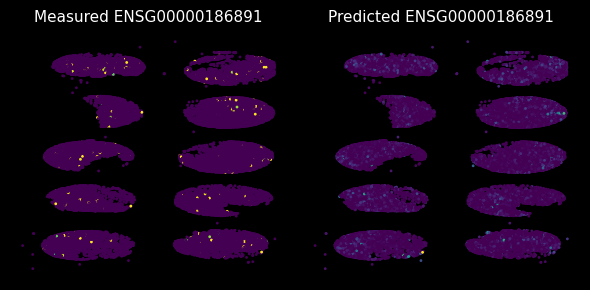

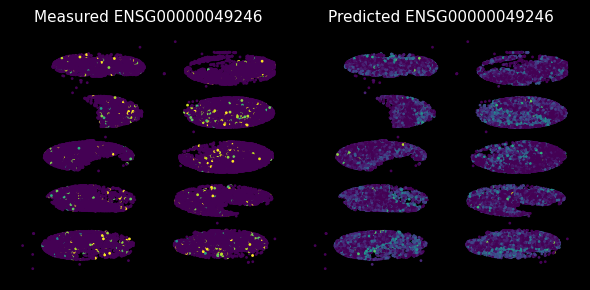

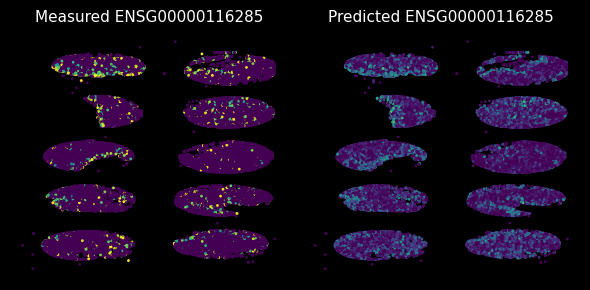

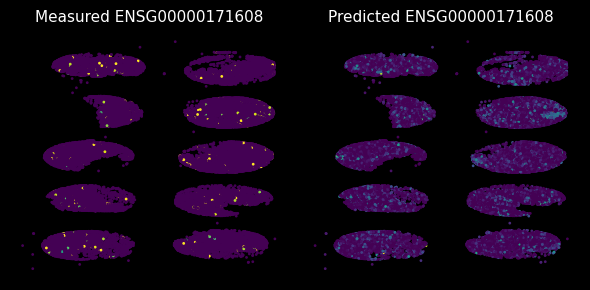

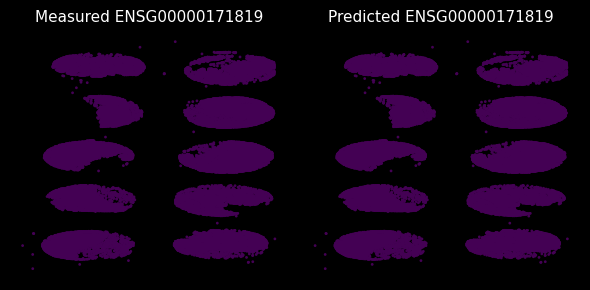

Spearman ρ
ENSG00000186891    0.130258
ENSG00000049246    0.151515
ENSG00000116285    0.275873
ENSG00000171608    0.151643
ENSG00000171819    0.108083
dtype: float64


In [114]:
# ---------- 5. Leave-one-gene-out SpaGE ----------
gene_set = common[:5]          # 데모용 5개
rho      = pd.Series(index=gene_set)
plt.style.use("dark_background")

for g in gene_set:
    pred = SpaGE(st_df, sc_df, n_pv=30, genes_to_predict=[g])
    rho[g] = st.spearmanr(st_df[g], pred[g])[0]

    vmax = np.percentile(st_df[g], 99)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    for ax, arr, ttl in [
        (ax1, st_df[g],  f"Measured {g}"),
        (ax2, pred[g],   f"Predicted {g}")]:
        ax.axis("off")
        ax.scatter(st_data_sub.obs["x_centroid"],
                   st_data_sub.obs["y_centroid"],
                   s=1, c=np.clip(arr, None, vmax))
        ax.set_title(ttl, fontsize=11)
    plt.tight_layout(); plt.show()

print("Spearman ρ")
print(rho)

### at once - time measure

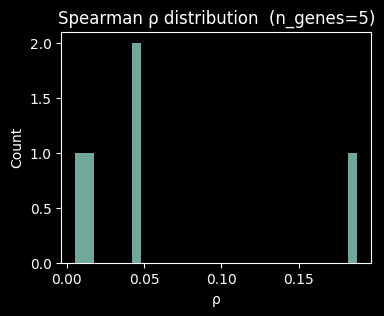

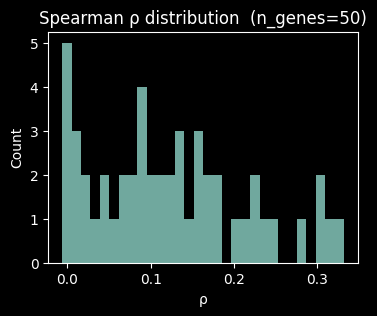

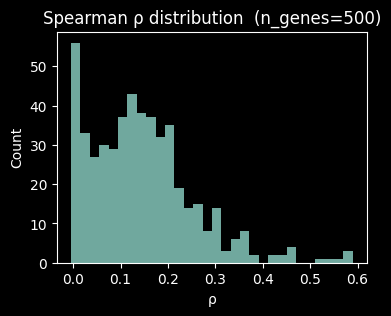

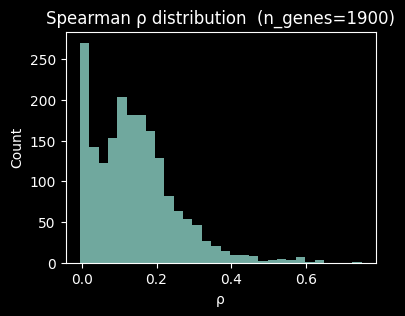

   n_genes    elapsed  rho_mean  rho_median   rho_IQR
0        5  49.578663  0.059355    0.043450  0.028149
1       50  50.586255  0.123259    0.113501  0.127953
2      500  53.316741  0.143987    0.130060  0.136849
3     1900  64.316327  0.141050    0.126371  0.138905


In [115]:
import time

# ------------------------------------------------------------
# 파라미터
sizes       = [5, 50, 500, 1900]          # 테스트할 gene set 크기
n_pv        = 30                    # partial vectors
rng         = np.random.default_rng(123)  # 재현성
spatial_df  = st_df                 # cells × genes (Measured)
rna_df      = sc_df                 # cells × genes (Reference)
genes_total = spatial_df.columns

# ------------------------------------------------------------
# 결과 저장용 리스트
records = []

for k in sizes:
    # ----- 1) 유전자 샘플링 -----------------------------------
    genes_k = rng.choice(genes_total, size=k, replace=False)

    # ----- 2) 실행 & 타이머 ----------------------------------
    tic = time.perf_counter()
    pred   = SpaGE(spatial_df, rna_df, n_pv=n_pv,
                   genes_to_predict=list(genes_k))
    dt     = time.perf_counter() - tic

    # ----- 3) 상관계수 계산 ----------------------------------
    rhos = [
        st.spearmanr(spatial_df[g], pred[g])[0]
        for g in genes_k
    ]
    rhos  = np.array(rhos)

    records.append({
        "n_genes" : k,
        "elapsed" : dt,
        "rho_mean": rhos.mean(),
        "rho_median": np.median(rhos),
        "rho_IQR" : np.percentile(rhos, 75) - np.percentile(rhos, 25)
    })

    # (선택) 분포 히스토그램/박스플롯 바로 보기
    plt.figure(figsize=(4,3))
    plt.hist(rhos, bins=30, alpha=.8)
    plt.title(f"Spearman ρ distribution  (n_genes={k})")
    plt.xlabel("ρ"); plt.ylabel("Count"); plt.show()

# ------------------------------------------------------------
# 결과 요약
summary = pd.DataFrame(records)
print(summary)

## 유전자명 추출 및 통일

In [15]:
st_data_sub.var_names = (
    st_data_sub.var["gene_ids"]
    .astype(str)                       # 문자열로
    .str.upper()                       # 대문자 통일(교집합 맞추기 편함)
    .str.split('.').str[0]             # 배전 정보(ENSG000001.1) 잘라내기
)
st_data_sub.var_names_make_unique()     # 혹시 겹치는 이름이 있으면 .1, .2 붙여줌

sc_data_sub.var_names = (
    sc_data_sub.var["ensembl"]
    .str.upper()
    .str.split('.').str[0]
)
sc_data_sub.var_names_make_unique()

# ---------- 0. 공통 유전자 찾기 ----------
sc_genes = sc_data_sub.var_names.str.upper()
st_genes = st_data_sub.var_names.str.upper()
common   = np.intersect1d(sc_genes, st_genes)
print(f"교집합 유전자: {len(common):,}개")

교집합 유전자: 1,996개


## 공통만

In [78]:
sc_common = sc_data_sub[:, sc_data_sub.var_names.isin(common)].copy()
st_common = st_data_sub[:, st_data_sub.var_names.isin(common)].copy()

In [79]:
# ---------- 3. AnnData → DataFrame (gene × cell) ----------
def adata_to_df(ad):
    X = ad.X.T
    if sp.issparse(X):
        X = X.toarray()            # 필요한 slice만 dense 로
    return pd.DataFrame(X,
                        index = ad.var_names,
                        columns = ad.obs_names)

sc_common.X = sc_common.layers['counts']
sc.pp.normalize_total(sc_common,target_sum=1e4,inplace=True)
sc.pp.log1p(sc_common)

st_common.X = st_common.layers['counts']
sc.pp.normalize_total(st_common,target_sum=1e2,inplace=True)
sc.pp.log1p(st_common)

sc_df = adata_to_df(sc_common)
st_df = adata_to_df(st_common)

print("sc_df shape:", sc_df.shape, "st_df shape:", st_df.shape)



sc_df shape: (1996, 4264) st_df shape: (1996, 6311)


In [ ]:
def remove_zero_var(df1, df2):
    """두 DataFrame 에서 표준편차 0 인 유전자 동시에 제거."""
    non_const = (df1.var(axis=0) > 0) & (df2.var(axis=0) > 0)
    return df1.loc[:, non_const], df2.loc[:, non_const]

def remove_zero_var2(df1, df2):
    """두 DataFrame 에서 표준편차 0 인 유전자 동시에 제거."""
    non_const = (df1.var(axis=1) > 0) & (df2.var(axis=1) > 0)
    return df1.loc[:, non_const], df2.loc[:, non_const]

st_df, sc_df=remove_zero_var(st_df.T,sc_df.T)
st_df, sc_df=remove_zero_var(st_df.T,sc_df.T)

In [91]:
# 성능 평가: corr

### Leave-one-gene-out cross validation for Lamp5, Kcnip2, Rorb, Tbr1 and Syt6
# Gene_set = st_data_sub.var_names[1:5]
# Correlations = pd.Series(index = Gene_set)
plt.style.use('dark_background')

# for i in Gene_set:
#     Imp_Genes = SpaGE(st_data_sub.T,sc_data_sub.T,n_pv=30,
#                            genes_to_predict = [i])
#     Correlations[i] = st.spearmanr(st_data_sub.T[i],Imp_Genes[i])[0]
    
#     fig, (ax1, ax2) = plt.subplots(1, 2)
#     ax1.axis('off')
#     cmap = st_data_sub.T[i]
#     cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
#     ax1.scatter(st_data_sub.obs['x_centroid'],st_data_sub.obs['y_centroid'],s=1,c=cmap)
#     ax1.set_title('Measured ' + i, fontsize = 12)
#     ax1.set_ylabel(i)
    
#     ax2.axis('off')
#     cmap = Imp_Genes[i]
#     cmap[cmap > np.percentile(cmap,99)] = np.percentile(cmap,99)
#     ax2.scatter(st_data_sub.obs['x_centroid'],st_data_sub.obs['y_centroid'],s=1,c=cmap)
#     ax2.set_title('Predicted ' + i, fontsize = 12)

# ---------- 4. Leave-one-gene-out CV ----------
common = np.intersect1d(sc_df.columns, st_df.columns)
gene_set  = common[:5]        # 데모: 앞 5개 유전자를 테스트
corr_s    = pd.Series(index = gene_set)
plt.style.use('dark_background')
for g in gene_set:
    imputed = SpaGE(st_df, sc_df, n_pv=30, genes_to_predict=[g])
    corr_s[g] = st.spearmanr(st_df.loc[,:g], imputed.loc[g])[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))
    for ax, dat, ttl in [
        (ax1, st_df.loc[g],        f"Measured {g}"),
        (ax2, imputed.loc[g],      f"Predicted {g}")]:
        vmax = np.percentile(dat, 99)
        ax.axis("off")
        ax.scatter(st_data_sub.obs["x_centroid"],
                   st_data_sub.obs["y_centroid"],
                   s=1, c=np.clip(dat, None, vmax))
        ax.set_title(ttl, fontsize=11)

    plt.tight_layout()
    plt.show()

print(corr_s)

/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/home/jaecheon/anaconda3/envs/scenvi/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:4266: FutureWarning: The behavior of DataFrame.var with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return var(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


KeyError: 'ENSG00000000938'

In [58]:
RNA_data
ST

# ---------- 1. 공통 유전자 추리기 ----------
for ad in (RNA_data, ST):
    ad.var["sym"] = ad.var_names.str.upper()      # 새 column에 대문자 기호 저장

common = np.intersect1d(RNA_data.var["sym"], ST.var["sym"])
print(f"교집합 유전자: {len(common):,}개")

# ---------- 2. AnnData 슬라이스 & gene 순서 통일 ----------
sc_common = RNA_data[:, RNA_data.var["sym"].isin(common)].copy()
st_common = ST[:, ST.var["sym"].isin(common)].copy()

# var_names 를 대문자 기호로 통일
sc_common.var_names = sc_common.var["sym"].values
st_common.var_names = st_common.var["sym"].values

# (선택) 알파벳 정렬 → 두 객체의 gene 순서 일치시킴
st_common = st_common[:, np.argsort(st_common.var_names)]
sc_common = sc_common[:, st_common.var_names]      # 동일 순서로 재배열

# ---------- 3. AnnData → DataFrame (gene × cell) ----------
def adata_to_df(ad):
    X = ad.X.T
    if sp.issparse(X):
        X = X.toarray()            # 필요한 slice만 dense 로
    return pd.DataFrame(X,
                        index = ad.var_names,
                        columns = ad.obs_names)

sc_df = adata_to_df(sc_common)
st_df = adata_to_df(st_common)

print("sc_df shape:", sc_df.shape, "st_df shape:", st_df.shape)

# ---------- 4. Leave-one-gene-out CV ----------
gene_set  = st_df.index[:5]        # 데모: 앞 5개 유전자를 테스트
corr_s    = pd.Series(index = gene_set)

for g in gene_set:
    imp = SpaGE(st_df, sc_df, n_pv = 30, genes_to_predict = [g])
    corr_s[g] = st.spearmanr(st_df.loc[g], imp.loc[g])[0]

    vmax = np.percentile(st_df.loc[g], 99)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (6, 3))

    for ax, arr, title in [
        (ax1, st_df.loc[g], f"Measured {g}"),
        (ax2, imp.loc[g],   f"Predicted {g}")]:
        ax.axis("off")
        ax.scatter(st_data_sub.obs["x_centroid"],
                   st_data_sub.obs["y_centroid"],
                   s = 1,
                   c = np.clip(arr, None, vmax))
        ax.set_title(title, fontsize = 11)
    plt.show()

print("Spearman ρ")
print(corr_s)

교집합 유전자: 0개
sc_df shape: (0, 42649) st_df shape: (0, 784669)
Spearman ρ
Series([], dtype: object)


In [ ]:
IMP=SpaGE(ST.T, RNA_data.T, n_pv=10)